Importando as principais bibliotecas, baixando e extraindo o Dataset.

In [1]:
from importlib.machinery import SourceFileLoader
dataset = SourceFileLoader('dataset', '/content/drive/My Drive/Colab Notebooks/Libraries/dataset.py').load_module()
models = SourceFileLoader('models','/content/drive/My Drive/Colab Notebooks/Libraries/models.py').load_module()
!pip install wget
import wget
data = wget.download('https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz') 
import tarfile
data = tarfile.open(data)
data.extractall()
import numpy as np
from sklearn.metrics import accuracy_score


In [ ]:
from importlib.machinery import SourceFileLoader
models = SourceFileLoader('models','/content/drive/My Drive/Colab Notebooks/Libraries/models.py').load_module()

Importando mais algumas bibliotecas e iniciando algumas das variáveis importantes.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA

comp = 20

#Declarando o objeto PCA aqui porque funciona melhor que declarar ele dentro da função DatasetGenerator.

pca = PCA(n_components=comp)   

INPUT_SHAPE = (98,comp,1)
BATCH = 8
EPOCHS = 20
DIR = '/content'

LABELS = 'go stop off right left down'.split()
NUM_CLASSES = len(LABELS)

Função DatasetGenerator modificada para realizar a transformada Wavelet e PCA.

In [ ]:
import os
import numpy as np
import pandas as pd
import random
    
from glob import glob

from scipy.io import wavfile
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras.utils import to_categorical

#pca = PCA(n_components=30)   


class DatasetGenerator_CWT():
    def __init__(self, label_set, 
                 sample_rate=16000):
        
        self.label_set = label_set
        self.sample_rate = sample_rate
            
    # Covert string to numerical classes              
    def text_to_labels(self, text):
        return self.label_set.index(text)
    
    # Reverse translation of numerical classes back to characters
    def labels_to_text(self, labels):
        return self.label_set[labels]               
        
    def load_data(self, DIR):

        # Get all paths inside DIR that ends with wav
        wav_files = glob(os.path.join(DIR, '*/*wav'))
        wav_files = [x.split(sep='/')[2] + '/' + x.split(sep='/')[3] for x in wav_files]
        
        # Loop over files to get samples
        data = []
        for e in wav_files:
            
            label, name = e.split('/')
            if label in self.label_set:
                label_id = self.text_to_labels(label)
                fle = os.path.join(DIR, e)
                
                sample = (label, label_id, name, fle)
                data.append(sample)
            
        # Data Frames with samples' labels and paths     
        df = pd.DataFrame(data, columns = ['label', 'label_id', 'user_id', 'wav_file'])
        
        self.df = df
        
        return self.df

    def apply_train_test_split(self, test_size, random_state):
        
        self.df_train, self.df_test = train_test_split(self.df, 
                                                       test_size=test_size,
                                                       random_state=random_state)
        
    def apply_train_val_split(self, val_size, random_state):
        
        self.df_train, self.df_val = train_test_split(self.df_train, 
                                                      test_size=val_size, 
                                                      random_state=random_state)
        
    def read_wav_file(self, x):
        # Read wavfile using scipy wavfile.read
        _, wav = wavfile.read(x) 
        # Normalize
        wav = wav.astype(np.float32) / np.iinfo(np.int16).max
            
        return wav
    def process_wav_file(self, x, threshold_freq=5500, eps=1e-10):
        # Read wav file to array
        wav = self.read_wav_file(x)
        # Sample rate
        L = self.sample_rate
        # If longer then randomly truncate
        if len(wav) > L:
            i = np.random.randint(0, len(wav) - L)
            wav = wav[i:(i+L)]  
        # If shorter then randomly add silence
        elif len(wav) < L:
            rem_len = L - len(wav)
            silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
            j = np.random.randint(0, rem_len)
            silence_part_left  = silence_part[0:j]
            silence_part_right = silence_part[j:rem_len]
            wav = np.concatenate([silence_part_left, wav, silence_part_right])
        # Create spectrogram using continous wavelet transform (time-frequency representation)
        times,dt = np.linspace(0, 1, 16000, retstep=True)
        fs = 1/dt
        freqs = np.linspace(1, fs/2, 98)
        w = 6
        widths = w*fs / (2*freqs*np.pi)
        spec = signal.cwt(wav, signal.morlet2, widths, w=w)
        # Cut high frequencies
        #if threshold_freq is not None:
        #    spec = spec[freqs <= threshold_freq,:]
        #    freqs = freqs[freqs <= threshold_freq]
        # Log spectrogram
        amp = np.log(np.abs(spec)+eps)
        pca_test = pca.fit(amp)
        pca_data = pca.transform(amp)
        amp = pca_data
        #return amp 
        return np.expand_dims(amp, axis=2) 

    def generator(self, batch_size, mode):
        while True:
            # Depending on mode select DataFrame with paths
            if mode == 'train':
                df = self.df_train 
                ids = random.sample(range(df.shape[0]), df.shape[0])
            elif mode == 'val':
                df = self.df_val
                ids = list(range(df.shape[0]))
            elif mode == 'test':
                df = self.df_test
                ids = list(range(df.shape[0]))
            else:
                raise ValueError('The mode should be either train, val or test.')
                
            # Create batches (for training data the batches are randomly permuted)
            for start in range(0, len(ids), batch_size):
                X_batch = []
                if mode != 'test': 
                    y_batch = []
                end = min(start + batch_size, len(ids))
                i_batch = ids[start:end]
                for i in i_batch:
                    X_batch.append(self.process_wav_file(df.wav_file.values[i]))
                    if mode != 'test':
                        y_batch.append(df.label_id.values[i])
                X_batch = np.array(X_batch)

                if mode != 'test':
                    y_batch = to_categorical(y_batch, num_classes = len(self.label_set))
                    yield (X_batch, y_batch)
                else:
                    yield X_batch
                                       

Criando o dataframe contendo os caminhos para os arquivos. 

In [ ]:
dsGen = DatasetGenerator_CWT(label_set=LABELS) 
# Load DataFrame with paths/labels for training and validation data 
# and paths for testing data 
df = dsGen.load_data(DIR)

dsGen.apply_train_test_split(test_size=0.3, random_state=2018)
dsGen.apply_train_val_split(val_size=0.2, random_state=2018)
print("Feito!")
df.head

Feito!


A célula abaixo cria uma lista contendo os arquivos processados pela função Process_wav_file, dentro do objeto DsGen. Foi necessário esse passo porque, aparentemente quando tentava usar o método "model.fit_generator" combinado com o PCA ele caia em um loop infinito. Criando uma lista com todos os PCAs isso não ocorre.

In [ ]:
df.head()
test = dsGen.process_wav_file(df.loc[1,"wav_file"])
test.shape 
data = []
len(df)
for i in range(len(df)):
  data.append(dsGen.process_wav_file(df.loc[i,"wav_file"]))
  print (i)


In [ ]:
df.head()
x = data
y = df["label_id"]

Divide em training set e testing set e converte as matrizes para np.array

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
#y_train = np.array(y_train)

Define as arquiteturas das Redes

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
                          
def deep(features_shape, num_classes, act='relu'):

    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(512, activation=act, name='dense1')(o)
    o = Dense(512, activation=act, name='dense2')(o)
    o = Dense(512, activation=act, name='dense3')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
    
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 

def deep_cnn(features_shape, num_classes, act='relu'):

    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)
    o = Dropout(0.3,name='block_2_drop')(o)

    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)

    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)

    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

def deep_cnn_matlab(features_shape, num_classes, act='relu'):

    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(16, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = BatchNormalization(name='block1_norm')(o)
    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='block1_pool')(o)

    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = BatchNormalization(name='block2_norm')(o)

    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='block2_pool')(o)

    # Block 3
    o = Dropout(0.2, name='dropout3')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = BatchNormalization(name='block3_norm')(o)

    # Block 4
    o = Dropout(0.2, name='dropout4')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block4_conv')(o)
    o = BatchNormalization(name='block4_norm')(o)
    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='block4_pool')(o)

    # Block 5
    o = Dropout(0.2, name='dropout5')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block5_conv')(o)
    o = BatchNormalization(name='block5_norm')(o)

    # Block 6
    o = Dropout(0.2, name='dropout6')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block6_conv')(o)
    o = BatchNormalization(name='block6_norm')(o)

    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)

    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

Treina uma rede neural utilizando a arquitetura "Deep_cnn".

In [ ]:
model = deep_cnn(INPUT_SHAPE, len(y_train.unique()))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
#callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
history = model.fit(X_train,
                    to_categorical(y_train,num_classes=len(y_train.unique())),batch_size=BATCH,epochs=100,verbose=1,
                    #callbacks=callbacks,
                    validation_split=0.2)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 98, 20, 1)         0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 98, 20, 32)        320       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 49, 10, 32)        0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 49, 10, 32)        128       
_________________________________________________________________
block2_conv (Conv2D)         (None, 49, 10, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 5, 32)         0         
_________________________________________________________________
block2_norm (BatchNormalizat (None, 25, 5, 32)         128 

Treina uma rede neural com a arquitetura "Deep_cnn_matlab", uma rede ainda mais profunda que tem um desempenho um pouco melhor nos dados utilizados. 

In [ ]:
model2 = deep_cnn_matlab(INPUT_SHAPE, len(y_train.unique()))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
#callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
history = model2.fit(X_train,
                    to_categorical(y_train,num_classes=len(y_train.unique())),batch_size=BATCH,epochs=100,verbose=1,
                    #callbacks=callbacks,
                    validation_split=0.2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 98, 20, 1)         0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 98, 20, 16)        160       
_________________________________________________________________
block1_norm (BatchNormalizat (None, 98, 20, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 49, 10, 16)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 49, 10, 32)        4640      
_________________________________________________________________
block2_norm (BatchNormalizat (None, 49, 10, 32)        128       
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 5, 32)         0   

Teste da performance da Rede Neural no Testing Set

In [ ]:
y_pred_proba=model.predict(np.array(X_test),verbose=1,batch_size=BATCH)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = y_test

acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

3551/3551 [==============================] - 0s 95us/step
0.7761194029850746


**XGBoost**: Utilizando o classificador XGBoost no dataset.

O primeiro passo é transformar as matrizes em arrays de 1 dimensão. Cada matriz 98x30 deverá se transformar em um vetor de 90*30 posições.


In [ ]:
X_train2 = X_train.reshape(8284,98*30)
X_train2.shape
X_test.shape
X_test2 = X_test.reshape(3551,98*30)

(8284, 2940)

In [ ]:
import xgboost as xgb
train = xgb.DMatrix(X_train2,label=y_train)
test = xgb.DMatrix(X_test2,label=y_test)

Os parâmetros de um classificador XGBoost são passados na forma de dicionário. 

In [ ]:
param = {
    'max_depth':20,
    'eta':0.5,
    'objective':'multi:softmax',
    'num_class': len(LABELS)}

Treina o modelo

In [ ]:
model = xgb.train(param,train,EPOCHS)

Para encontrar a melhor combinação de hyperparameters essa célula abaixo irá treinar diversos modelos diferentes e guardar as acurácios e os hiperparâmetros de uma matriz, possibilitando escolher futuramente o que melhor se adequar ao modelo.

In [ ]:
acc = []
iteração = 1
for i in range(10,100,10):
  for j in np.linspace(0.4,0.7,3):
    param = {
    'max_depth':i,
    'eta':j,
    'objective':'multi:softmax',
    'num_class': len(LABELS)}
    print(iteração)
    model = xgb.train(param,train,EPOCHS)
    y_pred = model.predict(test)
    acc.append([accuracy_score(y_pred,y_test),i,j])
    iteração = iteração+1
    




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
acc

[[0.4950718107575331, 1, 0.1],
 [0.5330892706279922, 1, 0.2],
 [0.5657561250352013, 1, 0.30000000000000004],
 [0.5767389467755561, 1, 0.4],
 [0.5885666009574768, 1, 0.5],
 [0.6003942551393974, 1, 0.6],
 [0.6063080822303576, 1, 0.7000000000000001],
 [0.6105322444381864, 1, 0.8],
 [0.6195437904815545, 1, 0.9],
 [0.617854125598423, 1, 1.0],
 [0.6184173472261335, 3, 0.1],
 [0.6584060827935793, 3, 0.2],
 [0.6817797803435652, 3, 0.30000000000000004],
 [0.6854407209236835, 3, 0.4],
 [0.686003942551394, 3, 0.5],
 [0.6907913263869333, 3, 0.6],
 [0.6941706561531963, 3, 0.7000000000000001],
 [0.7003660940580119, 3, 0.8],
 [0.691636158828499, 3, 0.9],
 [0.6857223317375387, 3, 1.0],
 [0.6685440720923683, 5, 0.1],
 [0.693889045339341, 5, 0.2],
 [0.7065615319628273, 5, 0.30000000000000004],
 [0.7045902562658406, 5, 0.4],
 [0.7119121374260772, 5, 0.5],
 [0.7102224725429457, 5, 0.6],
 [0.7096592509152352, 5, 0.7000000000000001],
 [0.6998028724303014, 5, 0.8],
 [0.7037454238242749, 5, 0.9],
 [0.69079132

In [ ]:
len(np.linspace(0.4,0.7,3))*len(range(10,100,10))

27

In [ ]:
y_pred = model.predict(test)
print(accuracy_score(y_test,y_pred))

0.7012109264995776


In [ ]:
X_train.shape

(13255, 98, 30, 1)

Classificador Suport Vector Machine (SVM).

SVM é um dos classificadores mais reconhecidos por sua versatilidade. As células abaixo testam ele nesse dataset. 

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train2)

clf = svm.SVC(C=30,kernel='rbf',gamma='scale')
clf.fit(scaler.transform(X_train2),y_train)

SVC(C=30, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
from sklearn import svm
clf = svm.SVC(C=1,kernel='poly',gamma='scale')
clf.fit(X_train2,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
scaler.fit(X_test2)
y_pred=clf.predict(scaler.transform(X_test2))
#y_pred = np.argmax(y_pred_proba, axis=1)

y_true = y_test

acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

0.6170092931568573


In [ ]:
len(y_train.unique())

9

In [ ]:
model = deep_cnn_matlab(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]

history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))



In [ ]:
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = dsGen.df_test['label_id'].values

acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

NameError: ignored

In [ ]:
model.save
model.save_weights

<bound method Network.save_weights of <keras.engine.training.Model object at 0x7fb98e1e76d8>>

In [ ]:
!mkdir -p saved_model
model.save_weights('saved_model/my_model_weights') 

In [ ]:
from distutils.dir_util import copy_tree

copy_tree('/content/saved_model','/content/drive/My Drive/Colab Notebooks')

['/content/drive/My Drive/Colab Notebooks/my_model_weights']

In [ ]:

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 



NameError: ignored

Testando como as bibliotecas de Wavelets de Python se comportam e aplicando PCA.

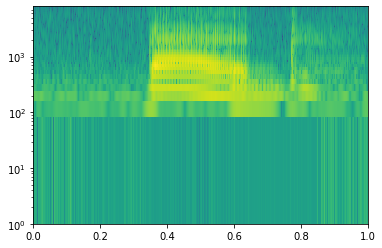

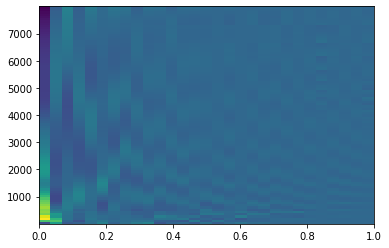

In [2]:
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
t, dt = np.linspace(0, 1, 16000, retstep=True)
t_pca, dt_pca = np.linspace(0,1,30,retstep=True)
fs = 1/dt
w = 6.
eps = 1e-10
_,sig = wavfile.read('/content/bed/00f0204f_nohash_0.wav')
_,sig2 = wavfile.read('/content/bed/00f0204f_nohash_1.wav')
_,sig3 = wavfile.read('/content/bed/004ae714_nohash_0.wav')
_,sig4 = wavfile.read('/content/bed/004ae714_nohash_1.wav')

#sig = np.cos(2*np.pi*(50 + 10*t)*t) + np.sin(40*np.pi*t)
freq = np.linspace(1, fs/2, 98)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(sig, signal.morlet2, widths, w=w)
amp1 = np.abs(cwtm)
amp2 = np.log(np.abs(cwtm)+eps)
pca.fit(amp2)
pca_data=pca.transform(amp2)
plt.pcolormesh(t, freq, amp2, cmap='viridis')
plt.yscale('log')
plt.show()
plt.pcolormesh(t_pca,freq,pca_data,cmap='viridis')


In [ ]:
sig_resample = signal.resample(sig,8000)

#plt.plot(sig)
#plt.plot(sig_resample)
##
t, dt = np.linspace(0, 1, 16000, retstep=True)
fs = 1/dt
tr, dtr = np.linspace(0, 1, 8000, retstep=True)
fsr = 1/dt
w = 6.

freq = np.linspace(1, fs/2, 98)
freqr = np.linspace(1, fsr/2, 98)
widths = w*fs / (2*freq*np.pi)
widthsr = w*fsr / (2*freqr*np.pi)
cwtm = signal.cwt(sig, signal.morlet2, widths, w=w)
cwtmr = signal.cwt(sig_resample, signal.morlet2, widthsr, w=w)
amp1 = np.abs(cwtm)
amp1r = np.abs(cwtmr)


#plt.pcolormesh(t, freq, amp1, cmap='viridis')
#plt.show()
#plt.pcolormesh(tr, freqr, amp1r, cmap='viridis')
#plt.show()
#amp1.shape


from scipy.fft import fft
# Number of sample points
# sample spacing
N = len(sig)
yf = fft(sig)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(sig*w)
xf = np.linspace(0.0, 1.0/(2.0*t), N//2)
import matplotlib.pyplot as plt
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/function_base.py:155: RuntimeWarning: invalid value encountered in multiply
  y = y * step


In [ ]:
np.expand_dims(pca_data, axis=2).shape

(98, 30, 1)

In [ ]:
amp1.shape
pca_data.shape

(98, 20)

In [ ]:
sig

(16000, array([ -77, -126,  -90, ..., -110,  -47,  -11], dtype=int16))

Plotando os componentes do PCA.

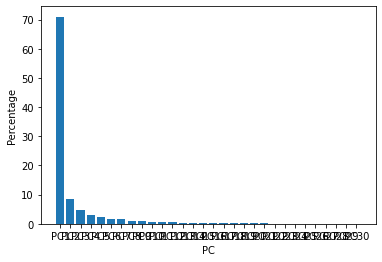

In [ ]:
per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels = ['PC'+str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage')
plt.xlabel('PC')
plt.show()

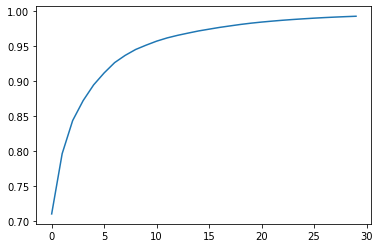

array([0.71043486, 0.7965973 , 0.84395165, 0.87250856, 0.8949873 ,
       0.91206649, 0.92682466, 0.93713059, 0.94558364, 0.95179705,
       0.95749913, 0.96211939, 0.96582859, 0.96902869, 0.97211185,
       0.97465372, 0.97716473, 0.9793092 , 0.98141438, 0.98323498,
       0.98479418, 0.98613786, 0.98739468, 0.98849203, 0.98947395,
       0.9903937 , 0.9912075 , 0.9919146 , 0.99254932, 0.99312765])

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

np.cumsum(pca.explained_variance_ratio_[0:30])

In [ ]:
df_train_pca = dsGen.process_wav_file
df_train_pca

<bound method DatasetGenerator_CWT.process_wav_file of <__main__.DatasetGenerator_CWT object at 0x7f039d9d55f8>>

In [ ]:
def read_wav_file(self, x):
        # Read wavfile using scipy wavfile.read
        _, wav = wavfile.read(x) 
        # Normalize
        wav = wav.astype(np.float32) / np.iinfo(np.int16).max
            
        return wav
    

In [ ]:
amp = np.amax(sig)
#plt.pcolormesh(times, freqs, np.abs(spec), vmin=0, vmax=amp)
plt.pcolormesh(np.arange(0,1,1/16000),79,np.abs(cwtmatr))

In [ ]:
freqs.shape, times.shape, spec.shape

((257,), (98,), (257, 98))

In [ ]:
np.arrange(0,1,1/16000)

In [ ]:
# Set the parameters of the scattering transform.
J = 6
T = 2 ** 13
Q = 8

# Generate a sample signal.
x = np.random.randn(T)

# Define a Scattering1D object.
S = ky.Scattering1D(J, T, Q)

# Calculate the scattering transform.
Sx = S.scattering(x)

# Equivalently, use the alias.
Sx = S(x)

In [ ]:
wav = read_wav_file(_,path)

In [ ]:
threshold_freq=5500
eps = 1e-10
L = 16000

In [ ]:
if len(wav) > L:
  i = np.random.randint(0, len(wav) - L)
  wav = wav[i:(i+L)]  
        # If shorter then randomly add silence
elif len(wav) < L:
  rem_len = L - len(wav)
  silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
  j = np.random.randint(0, rem_len)
  silence_part_left  = silence_part[0:j]
  silence_part_right = silence_part[j:rem_len]
  newwav = np.concatenate([silence_part_left, wav, silence_part_right])
  # Create spectrogram using discrete FFT (change basis to frequencies)
  #freqs, times, spec = stft(wav, L, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
  # Cut high frequencies
#if threshold_freq is not None:
 #  spec = spec[freqs <= threshold_freq,:]
  # freqs = freqs[freqs <= threshold_freq]
        # Log spectrogram
   #amp = np.log(np.abs(spec)+eps)
  spec.shape 

In [ ]:
freqs, times, spec = stft(wav, L, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
spec.shape
plt.plot(spec)

In [ ]:
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.plot(cwtmatr)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, L/len(wav), L), newwav)


NameError: ignored

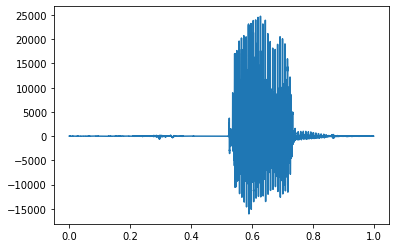

In [ ]:
dropoutProb = 0.2;
layers = [
    imageInputLayer(imageSize)

    convolution2dLayer(3,16,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2)

    convolution2dLayer(3,32,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2,'Padding',[0,1])

    dropoutLayer(dropoutProb)
    convolution2dLayer(3,64,'Padding','same')
    batchNormalizationLayer
    reluLayer

    dropoutLayer(dropoutProb)
    convolution2dLayer(3,64,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2,'Padding',[0,1])

    dropoutLayer(dropoutProb)
    convolution2dLayer(3,64,'Padding','same')
    batchNormalizationLayer
    reluLayer

    dropoutLayer(dropoutProb)
    convolution2dLayer(3,64,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer([1 13])

    fullyConnectedLayer(numClasses)
    softmaxLayer
    weightedCrossEntropyLayer(classNames,classWeights)];

    def deep_cnn_matlab(features_shape, num_classes, act='relu'):

    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(16, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = BatchNormalization(name='block1_norm')(o)
    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='block1_pool')(o)

    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = BatchNormalization(name='block2_norm')(o)

    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='block2_pool')(o)

    # Block 3
    o = Dropout(0.2, name='dropout3')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = BatchNormalization(name='block3_norm')(o)

    # Block 4
    o = Dropout(0.2, name='dropout4')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block4_conv')(o)
    o = BatchNormalization(name='block4_norm')(o)
    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='block2_pool')(o)

    # Block 5
    o = Dropout(0.2, name='dropout5')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block5_conv')(o)
    o = BatchNormalization(name='block5_norm')(o)

    # Block 6
    o = Dropout(0.2, name='dropout5')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='block6_conv')(o)
    o = BatchNormalization(name='block6_norm')(o)

    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)

    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)